In [1]:
%matplotlib inline 

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union
from pathlib import Path

import torch
import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm

from copy import deepcopy
from typing import Callable, List, Dict, Tuple, Optional

import shap
from captum.attr import IntegratedGradients

from sklearn.metrics import mean_squared_error

In [3]:
# Load full feature set filter to regular trading hours

df_all_features = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True).between_time(params.sess_start, params.sess_end)

# Separate feature matrix X and target vector y
all_features = [c for c in df_all_features.columns if c not in ['close_raw', params.label_col]]
X_all        = df_all_features[all_features]
y            = df_all_features[params.label_col]

print(all_features)

['volume', 'ret', 'log_ret', 'roc_14', 'body', 'body_pct', 'upper_shad', 'lower_shad', 'range_pct', 'rsi_14', 'macd_line_12_26_9', 'macd_signal_12_26_9', 'macd_diff_12_26_9', 'sma_pct_14', 'sma_pct_28', 'atr_14', 'atr_pct_14', 'bb_w_20', 'plus_di_14', 'minus_di_14', 'adx_14', 'obv', 'obv_diff_14', 'obv_pct_14', 'obv_sma_14', 'vol_spike_14', 'hour', 'day_of_week', 'month', 'eng_ma', 'eng_macd', 'eng_bb', 'eng_bb_mid', 'eng_rsi', 'eng_adx', 'eng_obv', 'eng_atr_div', 'eng_sma_short', 'eng_sma_long', 'eng_vwap']


Dropped low-variance features: ['roc_14', 'upper_shad', 'lower_shad', 'eng_ma', 'eng_macd', 'eng_bb_mid', 'eng_adx', 'eng_sma_short', 'eng_sma_long', 'eng_vwap']
Dropped high-correlation features: ['log_ret', 'macd_signal_12_26_9', 'obv_sma_14', 'ret']
Kept after std filter (count): 30
Kept after correlation pruning (count): 26


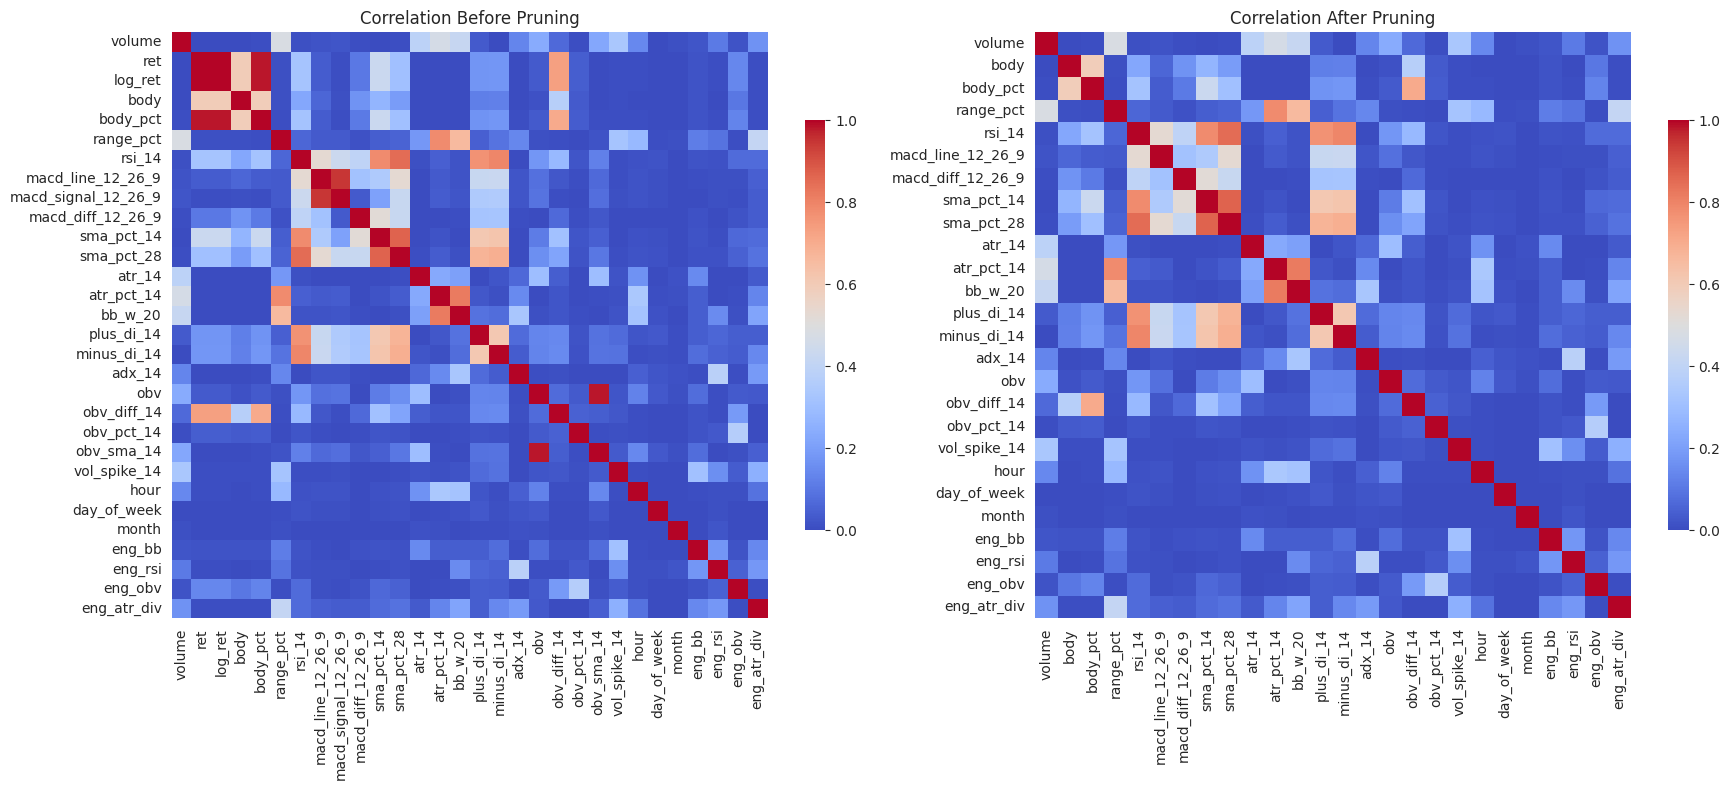

In [4]:
importlib.reload(params) #########

kept_after_std, pruned_feats, corr_full, corr_pruned = feats.prune_features_by_variance_and_correlation(
    X_all=X_all,
    y=y,
    min_std=params.feats_min_std,
    max_corr=params.feats_max_corr
)

# show heatmaps
feats.plot_correlation_before_after(corr_full, corr_pruned)

In [5]:
# build final feature DataFrame if needed
df_feat_prun = df_all_features[pruned_feats + [params.label_col] + ['close_raw']]

df_feat_prun

,volume,body,body_pct,range_pct,rsi_14,macd_line_12_26_9,macd_diff_12_26_9,sma_pct_14,sma_pct_28,atr_14,atr_pct_14,bb_w_20,plus_di_14,minus_di_14,adx_14,obv,obv_diff_14,obv_pct_14,vol_spike_14,hour,day_of_week,month,eng_bb,eng_rsi,eng_obv,eng_atr_div,signal,close_raw
2004-01-02 14:30:00,1.000000,0.513912,1.000000,1.000000,0.990316,0.494836,0.510680,1.000000,1.000000,0.002158,0.273678,0.878114,0.405934,0.136242,0.835045,0.000000,1.000000,0.419491,0.682133,0.201260,-0.977218,-0.123092,0.000000,0.967721,0.00000,1.000000,0.463747,0.772500
2004-01-02 14:31:00,0.455158,0.516678,1.000000,1.000000,0.992008,0.495319,0.511192,1.000000,1.000000,0.002996,0.379408,0.921733,0.359820,0.091129,0.817958,0.000000,1.000000,0.453105,0.427762,0.201260,-0.977218,-0.123092,0.002220,0.973361,0.00000,1.000000,0.423777,0.773571
2004-01-02 14:32:00,0.931212,0.514465,1.000000,1.000000,0.994892,0.496334,0.513046,1.000000,1.000000,0.003575,0.450939,1.000000,0.390934,0.070902,0.809030,0.000000,1.000000,0.394723,0.553429,0.201260,-0.977218,-0.123092,0.030718,0.982973,0.00000,1.000000,0.380621,0.776786
2004-01-02 14:33:00,0.213437,0.506538,0.499412,0.500105,0.953715,0.496974,0.513511,1.000000,1.000000,0.003650,0.460644,1.000000,0.355525,0.064480,0.800738,0.000000,0.110604,0.531049,0.213555,0.201260,-0.977218,-0.123092,0.006202,0.845716,0.96159,1.000000,0.333847,0.776429
2004-01-02 14:34:00,0.273285,0.502851,0.163166,0.501027,0.809406,0.497078,0.512430,1.000000,1.000000,0.003720,0.470330,1.000000,0.323928,0.058750,0.793040,0.000000,0.018838,0.536756,0.244383,0.201260,-0.977218,-0.123092,0.000000,0.364687,1.00000,1.000000,0.283178,0.775000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.362651,0.854984,0.624850,0.254109,0.672166,0.971125,0.888941,0.751690,0.747005,0.580814,0.323886,0.273759,0.363125,0.074852,0.301944,0.333024,1.000000,0.536512,0.358865,-0.975989,0.024469,0.605122,0.883846,0.000000,1.00000,0.664288,0.165471,196.815000
2025-06-18 20:57:00,0.434283,0.158091,0.374057,0.420131,0.616686,0.981544,0.840741,0.650094,0.674116,0.599850,0.336016,0.290460,0.347207,0.067044,0.328685,0.306009,0.000000,0.456298,0.375525,-0.975989,0.024469,0.605122,0.000000,0.000000,0.00000,0.676887,0.148438,196.675000
2025-06-18 20:58:00,0.496049,0.493632,0.494766,0.121620,0.614734,0.983006,0.777896,0.631153,0.659095,0.577674,0.322169,0.304199,0.336272,0.064933,0.353515,0.275205,0.000000,0.444697,0.380516,-0.975989,0.024469,0.605122,0.000000,0.000000,0.00000,0.584662,0.147712,196.670000
2025-06-18 20:59:00,1.000000,0.000000,0.090577,0.565110,0.475401,0.884486,0.456523,0.375519,0.478307,0.616017,0.346959,0.305249,0.290578,0.160021,0.348960,0.153481,0.000000,0.253560,0.650190,-0.975989,0.024469,0.605122,0.000000,0.000000,0.00000,0.645760,0.116676,196.240000


In [6]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_prun,
    look_back      = params.hparams["LOOK_BACK"],
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    train_workers  = params.hparams["TRAIN_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)

Inside build_tensors, features: ['volume', 'body', 'body_pct', 'range_pct', 'rsi_14', 'macd_line_12_26_9', 'macd_diff_12_26_9', 'sma_pct_14', 'sma_pct_28', 'atr_14', 'atr_pct_14', 'bb_w_20', 'plus_di_14', 'minus_di_14', 'adx_14', 'obv', 'obv_diff_14', 'obv_pct_14', 'vol_spike_14', 'hour', 'day_of_week', 'month', 'eng_bb', 'eng_rsi', 'eng_obv', 'eng_atr_div']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 3792  (2004-01-02 → 2019-01-25)
 windows       : 1258944  (per-day min=332, max=332, mean=332.0)
 window shape  : look_back=60, n_features=26
 dataloader    : batches=237, batch_size=16, workers=8, pin_memory=True

--- VAL ---
 calendar days : 799  (2019-01-28 → 2022-03-28)
 windows       : 265268  (per-day min=332, max=332, mean=332.0)
 window shape  : look_back=60, n_features=26
 dataloader    : batches=799, batch_size=1, workers=0, pin_memory=True

--- TEST ---
 calendar days : 809  (2022-03-29 → 2025-06-18)
 windows       : 268588  (per-day min=332, max=332, mean=332.0)
 window shape  : look_back=60, n_features=26
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True



In [7]:
# importlib.reload(models_custom) #############

# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = models_custom.ModelClass(
    n_feats             = len(pruned_feats),
    short_units         = params.hparams["SHORT_UNITS"],
    long_units          = params.hparams["LONG_UNITS"],
    transformer_d_model = 64,
    transformer_layers  = 1,
    dropout_short       = params.hparams["DROPOUT_SHORT"],
    dropout_long        = params.hparams["DROPOUT_LONG"],
    dropout_trans       = params.hparams["DROPOUT_TRANS"],
    pred_hidden         = params.hparams["PRED_HIDDEN"],
    window_len          = params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv            = False,
    use_tcn             = False,
    use_short_lstm      = False,
    use_transformer     = True,
    use_long_lstm       = False,
    use_delta           = False,
    flatten_mode        = params.hparams["FLATTEN_MODE"]
)

model.to(params.device)  
    
model

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (feature_proj): Linear(in_features=26, out_features=64, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (short2long

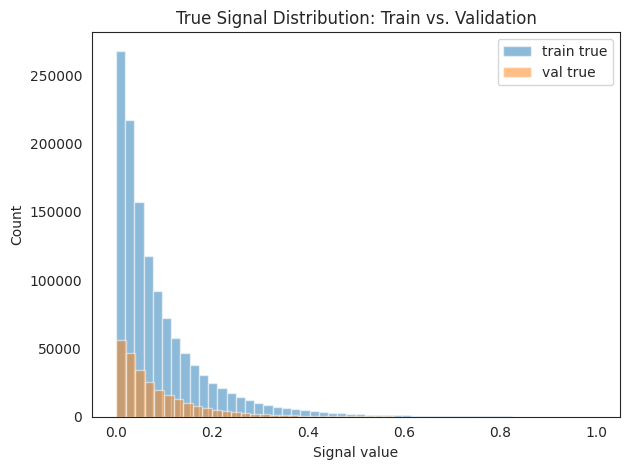

In [8]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])

# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=50, alpha=0.5, label="train true")
plt.hist(y_val,   bins=50, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
optimizer = AdamW(
  model.parameters(),
  lr           = params.hparams["ONECYCLE_MAX_LR"],
  weight_decay = params.hparams["WEIGHT_DECAY"]
)

batches_per_epoch = len(train_loader)
total_steps = batches_per_epoch * params.hparams["MAX_EPOCHS"]

scheduler = OneCycleLR(
  optimizer,
  max_lr           = 1.5e-4,
  total_steps      = total_steps,
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)
optimizer.scheduler = scheduler # necessary to log sched_field

if getattr(scheduler, "total_steps", None) != total_steps:
    raise RuntimeError(f"Scheduler total_steps mismatch: scheduler={getattr(scheduler,'total_steps',None)} expected={total_steps}")

scheduler

Training sees 3792 unique trading days per epoch.

Model parameters: total=77,443, trainable=77,443

Using HyperParameters:
 {'USE_CONV': False, 'CONV_K': 3, 'CONV_DILATION': 1, 'CONV_CHANNELS': 64, 'USE_TCN': False, 'TCN_LAYERS': 2, 'TCN_KERNEL': 3, 'TCN_CHANNELS': 64, 'USE_SHORT_LSTM': False, 'SHORT_UNITS': 128, 'DROPOUT_SHORT': 0.1, 'USE_TRANSFORMER': True, 'TRANSFORMER_D_MODEL': 128, 'TRANSFORMER_LAYERS': 3, 'TRANSFORMER_HEADS': 4, 'TRANSFORMER_FF_MULT': 4, 'DROPOUT_TRANS': 0.1, 'USE_LONG_LSTM': False, 'DROPOUT_LONG': 0.1, 'LONG_UNITS': 128, 'FLATTEN_MODE': 'pool', 'PRED_HIDDEN': 128, 'ALPHA_SMOOTH': 0.0, 'WARMUP_STEPS': 5, 'USE_HUBER': False, 'HUBER_DELTA': 0.1, 'USE_DELTA': False, 'LAMBDA_DELTA': 0.1, 'MAX_EPOCHS': 70, 'EARLY_STOP_PATIENCE': 7, 'WEIGHT_DECAY': 1e-05, 'CLIPNORM': 3, 'ONECYCLE_MAX_LR': 0.0005, 'ONECYCLE_DIV_FACTOR': 10, 'ONECYCLE_FINAL_DIV': 100, 'ONECYCLE_PCT_START': 0.1, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 16, 'VAL_BATCH': 1, 'TRAIN_WORKERS': 8, 'TRAIN_PRE

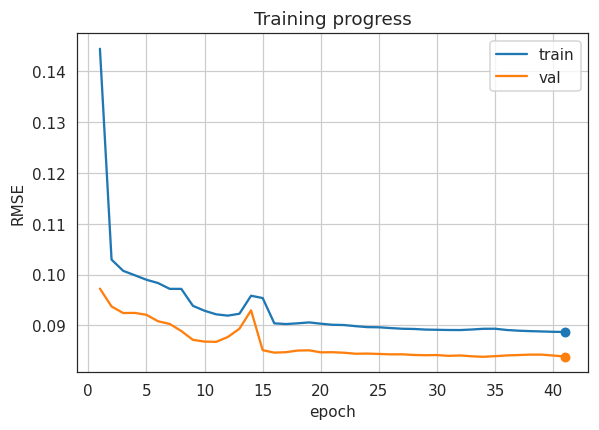

Epoch 1 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 01  TRAIN→ RMSE=0.14446, R²=-0.900 |  VALID→ RMSE=0.09722, R²=0.027 |  lr=2.16e-05 |  loss=2.08676e-02 |  improved=True


Epoch 2 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 02  TRAIN→ RMSE=0.10294, R²=0.035 |  VALID→ RMSE=0.09371, R²=0.096 |  lr=4.03e-05 |  loss=1.05962e-02 |  improved=True


Epoch 3 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 03  TRAIN→ RMSE=0.10073, R²=0.076 |  VALID→ RMSE=0.09242, R²=0.121 |  lr=6.74e-05 |  loss=1.01465e-02 |  improved=True


Epoch 4 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 04  TRAIN→ RMSE=0.09986, R²=0.092 |  VALID→ RMSE=0.09244, R²=0.120 |  lr=9.75e-05 |  loss=9.97141e-03 |  improved=False


Epoch 5 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 05  TRAIN→ RMSE=0.09897, R²=0.108 |  VALID→ RMSE=0.09207, R²=0.127 |  lr=1.25e-04 |  loss=9.79559e-03 |  improved=True


Epoch 6 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 06  TRAIN→ RMSE=0.09832, R²=0.120 |  VALID→ RMSE=0.09080, R²=0.151 |  lr=1.43e-04 |  loss=9.66744e-03 |  improved=True


Epoch 7 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 07  TRAIN→ RMSE=0.09718, R²=0.140 |  VALID→ RMSE=0.09027, R²=0.161 |  lr=1.50e-04 |  loss=9.44428e-03 |  improved=True


Epoch 8 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 08  TRAIN→ RMSE=0.09717, R²=0.140 |  VALID→ RMSE=0.08887, R²=0.187 |  lr=1.50e-04 |  loss=9.44241e-03 |  improved=True


Epoch 9 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 09  TRAIN→ RMSE=0.09384, R²=0.198 |  VALID→ RMSE=0.08714, R²=0.218 |  lr=1.50e-04 |  loss=8.80501e-03 |  improved=True


Epoch 10 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 10  TRAIN→ RMSE=0.09287, R²=0.215 |  VALID→ RMSE=0.08679, R²=0.224 |  lr=1.49e-04 |  loss=8.62442e-03 |  improved=True


Epoch 11 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 11  TRAIN→ RMSE=0.09216, R²=0.226 |  VALID→ RMSE=0.08674, R²=0.225 |  lr=1.49e-04 |  loss=8.49393e-03 |  improved=True


Epoch 12 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 12  TRAIN→ RMSE=0.09191, R²=0.231 |  VALID→ RMSE=0.08770, R²=0.208 |  lr=1.48e-04 |  loss=8.44674e-03 |  improved=False


Epoch 13 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 13  TRAIN→ RMSE=0.09228, R²=0.224 |  VALID→ RMSE=0.08933, R²=0.178 |  lr=1.47e-04 |  loss=8.51550e-03 |  improved=False


Epoch 14 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 14  TRAIN→ RMSE=0.09582, R²=0.164 |  VALID→ RMSE=0.09295, R²=0.111 |  lr=1.45e-04 |  loss=9.18227e-03 |  improved=False


Epoch 15 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 15  TRAIN→ RMSE=0.09537, R²=0.172 |  VALID→ RMSE=0.08510, R²=0.254 |  lr=1.44e-04 |  loss=9.09493e-03 |  improved=True


Epoch 16 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 16  TRAIN→ RMSE=0.09039, R²=0.256 |  VALID→ RMSE=0.08462, R²=0.263 |  lr=1.43e-04 |  loss=8.17054e-03 |  improved=True


Epoch 17 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 17  TRAIN→ RMSE=0.09025, R²=0.258 |  VALID→ RMSE=0.08471, R²=0.261 |  lr=1.41e-04 |  loss=8.14445e-03 |  improved=False


Epoch 18 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 18  TRAIN→ RMSE=0.09039, R²=0.256 |  VALID→ RMSE=0.08503, R²=0.256 |  lr=1.39e-04 |  loss=8.17029e-03 |  improved=False


Epoch 19 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 19  TRAIN→ RMSE=0.09057, R²=0.253 |  VALID→ RMSE=0.08507, R²=0.255 |  lr=1.37e-04 |  loss=8.20323e-03 |  improved=False


Epoch 20 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 20  TRAIN→ RMSE=0.09032, R²=0.257 |  VALID→ RMSE=0.08467, R²=0.262 |  lr=1.35e-04 |  loss=8.15721e-03 |  improved=False


Epoch 21 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 21  TRAIN→ RMSE=0.09011, R²=0.261 |  VALID→ RMSE=0.08470, R²=0.261 |  lr=1.32e-04 |  loss=8.11910e-03 |  improved=False


Epoch 22 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 22  TRAIN→ RMSE=0.09006, R²=0.261 |  VALID→ RMSE=0.08460, R²=0.263 |  lr=1.30e-04 |  loss=8.11011e-03 |  improved=True


Epoch 23 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 23  TRAIN→ RMSE=0.08983, R²=0.265 |  VALID→ RMSE=0.08440, R²=0.267 |  lr=1.27e-04 |  loss=8.06947e-03 |  improved=True


Epoch 24 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 24  TRAIN→ RMSE=0.08965, R²=0.268 |  VALID→ RMSE=0.08443, R²=0.266 |  lr=1.25e-04 |  loss=8.03650e-03 |  improved=False


Epoch 25 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 25  TRAIN→ RMSE=0.08961, R²=0.269 |  VALID→ RMSE=0.08436, R²=0.267 |  lr=1.22e-04 |  loss=8.02996e-03 |  improved=True


Epoch 26 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 26  TRAIN→ RMSE=0.08946, R²=0.271 |  VALID→ RMSE=0.08428, R²=0.269 |  lr=1.19e-04 |  loss=8.00256e-03 |  improved=True


Epoch 27 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 27  TRAIN→ RMSE=0.08932, R²=0.273 |  VALID→ RMSE=0.08429, R²=0.268 |  lr=1.16e-04 |  loss=7.97887e-03 |  improved=False


Epoch 28 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 28  TRAIN→ RMSE=0.08928, R²=0.274 |  VALID→ RMSE=0.08416, R²=0.271 |  lr=1.13e-04 |  loss=7.97086e-03 |  improved=True


Epoch 29 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 29  TRAIN→ RMSE=0.08916, R²=0.276 |  VALID→ RMSE=0.08411, R²=0.272 |  lr=1.09e-04 |  loss=7.94977e-03 |  improved=True


Epoch 30 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 30  TRAIN→ RMSE=0.08912, R²=0.277 |  VALID→ RMSE=0.08414, R²=0.271 |  lr=1.06e-04 |  loss=7.94197e-03 |  improved=False


Epoch 31 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 31  TRAIN→ RMSE=0.08908, R²=0.277 |  VALID→ RMSE=0.08398, R²=0.274 |  lr=1.02e-04 |  loss=7.93454e-03 |  improved=True


Epoch 32 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 32  TRAIN→ RMSE=0.08907, R²=0.277 |  VALID→ RMSE=0.08406, R²=0.272 |  lr=9.89e-05 |  loss=7.93321e-03 |  improved=False


Epoch 33 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 33  TRAIN→ RMSE=0.08918, R²=0.276 |  VALID→ RMSE=0.08390, R²=0.275 |  lr=9.54e-05 |  loss=7.95221e-03 |  improved=True


Epoch 34 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 34  TRAIN→ RMSE=0.08932, R²=0.273 |  VALID→ RMSE=0.08380, R²=0.277 |  lr=9.17e-05 |  loss=7.97766e-03 |  improved=True


Epoch 35 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 35  TRAIN→ RMSE=0.08932, R²=0.273 |  VALID→ RMSE=0.08392, R²=0.275 |  lr=8.81e-05 |  loss=7.97876e-03 |  improved=False


Epoch 36 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 36  TRAIN→ RMSE=0.08908, R²=0.277 |  VALID→ RMSE=0.08406, R²=0.272 |  lr=8.44e-05 |  loss=7.93500e-03 |  improved=False


Epoch 37 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 37  TRAIN→ RMSE=0.08894, R²=0.280 |  VALID→ RMSE=0.08415, R²=0.271 |  lr=8.07e-05 |  loss=7.91045e-03 |  improved=False


Epoch 38 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 38  TRAIN→ RMSE=0.08885, R²=0.281 |  VALID→ RMSE=0.08423, R²=0.270 |  lr=7.69e-05 |  loss=7.89519e-03 |  improved=False


Epoch 39 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 39  TRAIN→ RMSE=0.08879, R²=0.282 |  VALID→ RMSE=0.08423, R²=0.270 |  lr=7.32e-05 |  loss=7.88381e-03 |  improved=False


Epoch 40 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 40  TRAIN→ RMSE=0.08872, R²=0.283 |  VALID→ RMSE=0.08405, R²=0.273 |  lr=6.95e-05 |  loss=7.87150e-03 |  improved=False


Epoch 41 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 41  TRAIN→ RMSE=0.08870, R²=0.284 |  VALID→ RMSE=0.08385, R²=0.276 |  lr=6.58e-05 |  loss=7.86710e-03 |  improved=False
✅ Final‐best model saved: AAPL_0.08380_fin.pth


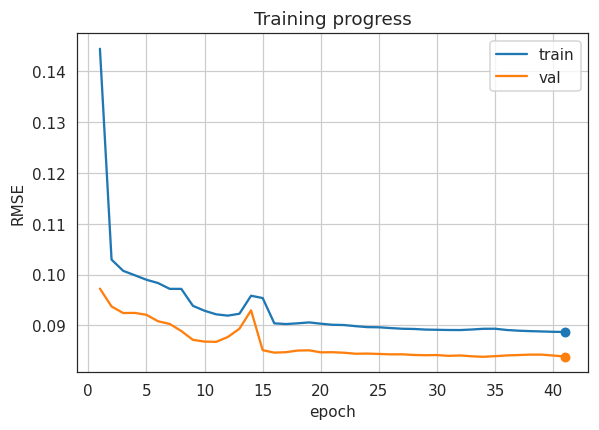

In [10]:
importlib.reload(params) #############
importlib.reload(models_custom) #############
importlib.reload(models_core) #############

n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: total={total_params:,}, trainable={trainable_params:,}\n")

print('Using HyperParameters:\n', params.hparams)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models_custom.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader,
)


In [19]:
# retrieve model just trained (keep exactly 5 decimals)
fname = f"{params.ticker}_{best_val_rmse:.5f}_fin.pth"
chk = Path(params.models_folder) / fname

# load checkpoint and recreate model from stored hparams
ckpt = torch.load(chk, map_location="cpu", weights_only=False)
h = ckpt["hparams"]

# load weights, move to device, set eval
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print("Loaded checkpoint:", chk)

Loaded checkpoint: trainings/AAPL_0.08380_fin.pth


In [20]:
print('Calculating Train metrics and predictions...')
_, _, train_preds, _, _ = \
    models_custom.eval_on_loader(train_loader, model)

print('Calculating Val metrics and predictions...')
_, _, val_preds, _, _  = \
    models_custom.eval_on_loader(val_loader,   model)

print('Calculating Test metrics and predictions...')
_, _, test_preds, _, _ = \
    models_custom.eval_on_loader(test_loader,  model)

Calculating Train metrics and predictions...


eval:   0%|          | 0/237 [00:00<?, ?it/s]

Calculating Val metrics and predictions...


eval:   0%|          | 0/799 [00:00<?, ?it/s]

Calculating Test metrics and predictions...


eval:   0%|          | 0/809 [00:00<?, ?it/s]

In [21]:
_, df_test = models_custom.add_preds_and_split(
    df            = df_feat_prun,
    train_preds   = train_preds,
    val_preds     = val_preds,
    test_preds    = test_preds,
    end_times_tr  = end_times_tr,
    end_times_val = end_times_val,
    end_times_te  = end_times_te
)

df_test

,volume,body,body_pct,range_pct,rsi_14,macd_line_12_26_9,macd_diff_12_26_9,sma_pct_14,sma_pct_28,atr_14,atr_pct_14,bb_w_20,plus_di_14,minus_di_14,adx_14,obv,obv_diff_14,obv_pct_14,vol_spike_14,hour,day_of_week,month,eng_bb,eng_rsi,eng_obv,eng_atr_div,signal,close_raw,pred_signal
2022-03-29 15:29:00,0.242146,0.767486,0.603631,0.159363,0.557069,0.384536,0.890175,0.706351,0.585023,0.603264,0.374942,0.303708,0.245458,0.227987,0.152505,0.234143,0.827690,0.541221,0.267345,-0.059203,0.797795,0.798398,0.000000,0.0,1.0,0.222874,0.039879,177.3811,0.129722
2022-03-29 15:30:00,0.176724,0.493632,0.494261,0.138650,0.555280,0.447221,0.983446,0.676204,0.588599,0.581331,0.359739,0.288191,0.252634,0.220656,0.146438,0.222930,0.166897,0.469475,0.215552,-0.059203,0.797795,0.798398,0.000000,0.0,0.0,0.177866,0.042671,177.3750,0.128768
2022-03-29 15:31:00,0.228974,0.145186,0.355174,0.233100,0.515792,0.467290,0.942512,0.581526,0.533402,0.572247,0.353745,0.266171,0.238745,0.246111,0.137063,0.208511,0.086782,0.458376,0.261887,-0.059203,0.797795,0.798398,0.000000,0.0,0.0,0.173417,0.044317,177.2400,0.111763
2022-03-29 15:32:00,0.251323,0.300051,0.416925,0.257753,0.493400,0.465771,0.851230,0.529365,0.498187,0.566764,0.350130,0.265775,0.224082,0.254393,0.131798,0.192722,0.052513,0.449652,0.279543,-0.059203,0.797795,0.798398,0.000000,0.0,0.0,0.176648,0.047158,177.1600,0.094902
2022-03-29 15:33:00,0.242137,0.093564,0.334373,0.356247,0.453634,0.432046,0.690880,0.434690,0.439799,0.573570,0.355117,0.266585,0.205328,0.296594,0.135371,0.177495,0.066599,0.444731,0.271207,-0.059203,0.797795,0.798398,0.000000,0.0,0.0,0.212393,0.046738,177.0100,0.079818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.362651,0.854984,0.624850,0.254109,0.672166,0.971125,0.888941,0.751690,0.747005,0.580814,0.323886,0.273759,0.363125,0.074852,0.301944,0.333024,1.000000,0.536512,0.358865,-0.975989,0.024469,0.605122,0.883846,0.0,1.0,0.664288,0.165471,196.8150,0.243522
2025-06-18 20:57:00,0.434283,0.158091,0.374057,0.420131,0.616686,0.981544,0.840741,0.650094,0.674116,0.599850,0.336016,0.290460,0.347207,0.067044,0.328685,0.306009,0.000000,0.456298,0.375525,-0.975989,0.024469,0.605122,0.000000,0.0,0.0,0.676887,0.148438,196.6750,0.201882
2025-06-18 20:58:00,0.496049,0.493632,0.494766,0.121620,0.614734,0.983006,0.777896,0.631153,0.659095,0.577674,0.322169,0.304199,0.336272,0.064933,0.353515,0.275205,0.000000,0.444697,0.380516,-0.975989,0.024469,0.605122,0.000000,0.0,0.0,0.584662,0.147712,196.6700,0.164491
2025-06-18 20:59:00,1.000000,0.000000,0.090577,0.565110,0.475401,0.884486,0.456523,0.375519,0.478307,0.616017,0.346959,0.305249,0.290578,0.160021,0.348960,0.153481,0.000000,0.253560,0.650190,-0.975989,0.024469,0.605122,0.000000,0.0,0.0,0.645760,0.116676,196.2400,0.109576
